In [1]:
import torch
# Choose the `slowfast_r50` model 
model = torch.hub.load('facebookresearch/pytorchvideo', 'slowfast_r101', pretrained=True)

Using cache found in /home/aiscuser/.cache/torch/hub/facebookresearch_pytorchvideo_main


In [2]:
from typing import Dict
import json
import urllib
from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)
from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample,
    UniformCropVideo
)

/home/aiscuser/.conda/envs/vidmodex/lib/python3.10/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/home/aiscuser/.conda/envs/vidmodex/lib/python3.10/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


In [3]:
device = "cuda:1"
model = model.eval()
model = model.to(device)

In [4]:
side_size = 256
mean = [0.45, 0.45, 0.45]
std = [0.225, 0.225, 0.225]
crop_size = 256
num_frames = 32
sampling_rate = 2
frames_per_second = 30
slowfast_alpha = 4
num_clips = 10
num_crops = 3

class PackPathway(torch.nn.Module):
    """
    Transform for converting video frames as a list of tensors. 
    """
    def __init__(self):
        super().__init__()
        
    def forward(self, frames: torch.Tensor):
        fast_pathway = frames
        # Perform temporal sampling from the fast pathway.
        slow_pathway = torch.index_select(
            frames,
            1,
            torch.linspace(
                0, frames.shape[1] - 1, frames.shape[1] // slowfast_alpha
            ).long(),
        )
        frame_list = [slow_pathway, fast_pathway]
        return frame_list

inverse_subsample = ApplyTransformToKey(
    key="video",
    transform = Compose(
        [
            NormalizeVideo(
                mean= [-m/s for m, s in zip(mean, std)],
                std= [1/s for s in std]
            ),
            Lambda(lambda x: x*255),
        ]
    ),
)
transform_subsample = ApplyTransformToKey(
    key="video",
    transform = Compose(
        [
            UniformTemporalSubsample(num_frames),
            Lambda(lambda x: x/255.0),
            NormalizeVideo(mean, std),
            ShortSideScale(
                size=side_size
            ),
            CenterCropVideo(crop_size),
        ]
    ),
)

transform =  ApplyTransformToKey(
    key="video",
    transform=Compose(
        [
            # UniformTemporalSubsample(num_frames),
            # Lambda(lambda x: x/255.0),
            # NormalizeVideo(mean, std),
            # ShortSideScale(
            #     size=side_size
            # ),
            # CenterCropVideo(crop_size),
            PackPathway()
        ]
    ),
)

# The duration of the input clip is also specific to the model.
clip_duration = (num_frames * sampling_rate)/frames_per_second

In [5]:
url_link = "https://dl.fbaipublicfiles.com/pytorchvideo/projects/archery.mp4"
video_path = 'archery.mp4'
try: urllib.URLopener().retrieve(url_link, video_path)
except: urllib.request.urlretrieve(url_link, video_path)

In [7]:
video_path = 'vidmodex_output_16.avi'
video_path='makeup.avi'
# video_path = 'archery.mp4'

In [8]:
start_sec = 0
end_sec = start_sec + clip_duration

# Initialize an EncodedVideo helper class and load the video
video = EncodedVideo.from_path(video_path)

# Load the desired clip
video_data_raw = video.get_clip(start_sec=start_sec, end_sec=end_sec)
video_data_raw = transform_subsample(video_data_raw)
# Apply a transform to normalize the video input
video_data = transform(video_data_raw)

# Move the inputs to the desired device
inputs = video_data["video"]
inputs = [i.to(device)[None, ...] for i in inputs]

In [9]:
video_data_raw = video.get_clip(start_sec=start_sec, end_sec=end_sec)
print(video_data_raw["video"].mean(), video_data_raw["video"].std(), video_data_raw["video"].min(), video_data_raw["video"].max())

video_data_raw = transform_subsample(video_data_raw)
print(video_data_raw["video"].mean(), video_data_raw["video"].std(), video_data_raw["video"].min(), video_data_raw["video"].max())
video_data_raw = inverse_subsample(video_data_raw)
print(video_data_raw["video"].mean(), video_data_raw["video"].std(), video_data_raw["video"].min(), video_data_raw["video"].max())
video_data_raw = transform_subsample(video_data_raw)
print(video_data_raw["video"].mean(), video_data_raw["video"].std(), video_data_raw["video"].min(), video_data_raw["video"].max())


tensor(73.9470) tensor(49.7335) tensor(0.) tensor(255.)
tensor(-0.7398) tensor(0.8536) tensor(-2.) tensor(2.4444)
tensor(72.3065) tensor(48.9729) tensor(0.) tensor(255.)
tensor(-0.7398) tensor(0.8536) tensor(-2.) tensor(2.4444)


In [10]:
import gc
from multiprocessing import Pool

def fetch_topk_probs(preds, k=5):
    topk_probs, topk_idxs = preds.topk(k)
    mask = torch.zeros_like(preds, dtype=torch.bool)
    mask.scatter_(1, topk_idxs, True)
    # mask = torch.zeros_like(preds)
    # mask[torch.arange(mask.size(0)), topk_idxs] = 1.
    rem_prob = (1. - topk_probs.sum(-1))/(preds.shape[-1]-k)
    out_probs = torch.einsum("j,jk->jk",rem_prob, torch.ones(preds.shape).to(device=preds.device))
    out_probs[mask.to(dtype=torch.bool)] = preds[mask.to(dtype=torch.bool)]
    # out_probs.index_put_((topk_idxs[], topk_idxs[]), topk_probs)
    # print(torch.index_select(out_probs, 1, topk_idxs))
    return out_probs

def call_vid(videos):
    input_slow = []
    input_fast = []
    print("batch_size", videos.shape[0])
    for i in range(videos.shape[0]):
        vid = {"video":torch.from_numpy(videos[i,...])}
        video_dict = transform(vid)
        inputs = video_dict["video"]
        input_slow.append(inputs[0].to(device))
        input_fast.append(inputs[1].to(device))
        
    input_slow = torch.stack(input_slow, dim=0).to(device)
    input_fast = torch.stack(input_fast, dim=0).to(device)
    with torch.no_grad():
        pred = model([input_slow, input_fast])
        post_act = torch.nn.Softmax(dim=1)
        preds = post_act(pred)
    
    torch.cuda.empty_cache()
    gc.collect()
    return fetch_topk_probs(preds,5)

def fetch_transformed_video(inputs):
    print(inputs["video"].shape)
    vid = {"video":torch.from_numpy(inputs["video"])}
    video_dict = inputs["transform"](vid)
    inputs = video_dict["video"]
    return inputs[0], inputs[1]

def fast_call_vid(videos):
    with Pool(min(64, videos.shape[0])) as p:
        results = p.map(fetch_transformed_video, [ {"video":videos[i,...], "transform":transform} for i in range(videos.shape[0])])
    print(results)
    input_slow = torch.stack([r[0] for r in results], dim=0).to(device)
    input_fast = torch.stack([r[1] for r in results], dim=0).to(device)
    with torch.no_grad():
        pred = model([input_slow, input_fast])
        post_act = torch.nn.Softmax(dim=1)
        preds = post_act(pred)
    
    torch.cuda.empty_cache()
    gc.collect()
    return fetch_topk_probs(preds,5)
    

In [11]:
from vidmodex.loss import ShapLoss


/home/aiscuser/.conda/envs/vidmodex/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
import numpy as np
from torch.nn import functional as F
scale_factor = [0.5, 0.25, 0.25]
inv_scale_factor = [1/s for s in scale_factor]
one_downsample = lambda x: np.ones((*x.shape[:-4], int(x.shape[-3]*scale_factor[0]), int(x.shape[-2]*scale_factor[1]), int(x.shape[-1]*scale_factor[2])), dtype=x.dtype)

def vid_downsample_fn(x):
    scale_factor = [1., 0.5, 0.5]
    if isinstance(x, torch.Tensor):
        return F.interpolate(x.reshape(-1, *x.shape), scale_factor=scale_factor, mode='trilinear', align_corners=False)[0]
    else:
        return F.interpolate(torch.from_numpy(x.reshape(-1, *x.shape)), scale_factor=scale_factor, mode='trilinear', align_corners=False).detach().cpu().numpy()[0]

def mask_upsample_fn(x):
    scale_factor = [1., 0.5, 0.5]
    inv_scale_factor = [1/s for s in scale_factor]
    if isinstance(x, torch.Tensor):
        return F.interpolate(x, scale_factor=inv_scale_factor, mode='nearest-exact')
    else:
        return  F.interpolate(torch.from_numpy(x), scale_factor=inv_scale_factor, mode='nearest-exact').detach().cpu().numpy()
#     mask = mask
#     base_input = base_input.detach().cpu().numpy()
#     return base_input[~mask]
# mask_upsample_fn = lambda x, base_input: np.ones((*x.shape[:-4], int(x.shape[-3]/scale_factor[0]), int(x.shape[-2]/scale_factor[1]), int(x.shape[-1]/scale_factor[2])), dtype=x.dtype)

In [13]:
def dummy_call(vid):
    out = torch.randn(vid.shape[0], 400)
    return F.softmax(out, dim=-1)

In [13]:
loss = ShapLoss(lambda x: x, video_data_raw["video"], num_classes=400, max_evals=128, inp_transform=vid_downsample_fn, inp_inverse_transform=mask_upsample_fn)
loss = loss.to(device)

/home/aiscuser/.conda/envs/vidmodex/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
loss2 = ShapLoss(lambda x: x, video_data_raw["video"], num_classes=400, max_evals=128) #, inp_transform=vid_downsample_fn, inp_inverse_transform=mask_upsample_fn)
loss2 = loss2.to(device)

In [ ]:
loss3 = ShapLoss(lambda x: x, video_data_raw["video"], num_classes=400, max_evals=128, inp_transform=vid_downsample_fn, inp_inverse_transform=mask_upsample_fn)
loss3 = loss3.to(device)

In [ ]:
import shap
loss.explainer.model = shap.models.Model(call_vid)
loss2.explainer.model = shap.models.Model(call_vid)
loss3.explainer.model = shap.models.Model(call_vid)

In [ ]:
max_evals = 64
loss.set_max_evals(max_evals)
loss2.set_max_evals(2*max_evals)
loss3.set_max_evals(2*max_evals)

In [14]:
X = video_data_raw["video"]

In [15]:
from torch import nn
import sys
sys.path.append("/home/aiscuser")
from discriminator_models import ConditionalShapDiscriminator
sys.path.pop(-1)
shap_prob_model = ConditionalShapDiscriminator(n_channels=3, out_channels=1, n_classes=400, width_multiplier=1, trilinear=True, prob_out=True, use_ds_conv=False) #.to('cuda:0')

checkpoint = torch.load("/home/aiscuser/discriminator/discriminator/unet2_prob/version_46/checkpoints/epoch=99-step=2100.ckpt")
for key in list(checkpoint["state_dict"].keys()):
    if "model." in key:
        checkpoint["state_dict"][key.replace("model.","")] = checkpoint["state_dict"].pop(key)
shap_prob_model.load_state_dict(checkpoint["state_dict"])


<All keys matched successfully>

In [16]:
cls_id = call_vid(X.reshape(-1, *X.shape).numpy()).argsort(-1).flip(-1)[...,0].cpu()

batch_size 1


In [17]:
cls_id

tensor([126])

In [18]:
mu, logvar = shap_prob_model(X.reshape(-1, *X.shape), cls_id)
sigma = torch.exp(0.5 * logvar)

In [19]:
torch.cuda.empty_cache()

In [ ]:
loss.batch_size = 128
loss2.batch_size = 128
loss3.batch_size = 128

In [ ]:
loss_item, (shap_gt, shap_gt_abs_max_val, target_outputs) = loss(X.reshape(-1, *X.shape), mu, sigma, optimize_prob=True, optimize_energy=False)

batch_size 1
batch_size 1
batch_size 2
batch_size 8
batch_size 32
batch_size 20


In [ ]:
loss_item2, (shap_gt2, shap_gt_abs_max_val2, target_outputs2) = loss2(X.reshape(-1, *X.shape), mu, sigma, optimize_prob=True, optimize_energy=False)

batch_size 1
batch_size 1
batch_size 2
batch_size 8
batch_size 32
batch_size 84


PartitionExplainer explainer: 2it [00:10, 10.71s/it]               


In [ ]:
loss_item3, (shap_gt3, shap_gt_abs_max_val3, target_outputs3) = loss3(X.reshape(-1, *X.shape), mu, sigma, optimize_prob=True, optimize_energy=False)

batch_size 1


batch_size 1
batch_size 2
batch_size 8
batch_size 32
batch_size 84


PartitionExplainer explainer: 2it [00:11, 11.22s/it]               


In [ ]:
target_outputs

[126]

In [ ]:
inp = X.reshape(-1, *X.shape).repeat_interleave(5,dim=0)
inp  = inp + torch.randn_like(inp)*0.2
loss_item, (shap_gt, shap_gt_abs_max_val, target_cls) = loss(inp, mu.repeat_interleave(5,dim=0), sigma.repeat_interleave(5,dim=0), class_idx=shap.Explanation.argsort.flip[[0]], optimize_prob=True, optimize_energy=False, shap_gt=None)

PartitionExplainer explainer: 6it [00:38,  9.72s/it]                       


In [ ]:
loss_item2, (shap_gt2, shap_gt_abs_max_val2, target_cls2) = loss2(inp, mu.repeat_interleave(5,dim=0), sigma.repeat_interleave(5,dim=0), class_idx=shap.Explanation.argsort.flip[[0]], optimize_prob=True, optimize_energy=False, shap_gt=None)

PartitionExplainer explainer: 6it [01:01, 12.33s/it]                       


In [ ]:
import numpy as np
if isinstance(target_cls, list):
    target_cls = (target_cls[0]*np.ones((inp.shape[0],1))).astype(np.int64)

In [ ]:
target_cls

array([[126],
       [126],
       [126],
       [126],
       [126]])

In [20]:
import shap
from shap.plots.colors import red_transparent_blue

In [21]:
svs = mu.detach().cpu().numpy().reshape(-1, 256, 256)

In [22]:
def subsample_xy_t(video, subsample_xy=True, n_xy=10, subsample_t=False, n_t=3):
    if subsample_xy:
        video = video[:, ::n_xy, ::n_xy]
        
    if subsample_t:
        video = video[::n_t, :, :]
    return video

In [23]:
svs = subsample_xy_t(svs)

In [30]:
svs = svs - svs.min()

In [25]:
svs -= 0.1

In [43]:
svs *= 1.2

In [48]:
from matplotlib import pyplot as plt
facecolor_s = red_transparent_blue(svs)

In [49]:
svs.mean(), svs.max(), svs.min()

(0.5675488, 0.8926367, 0.0)

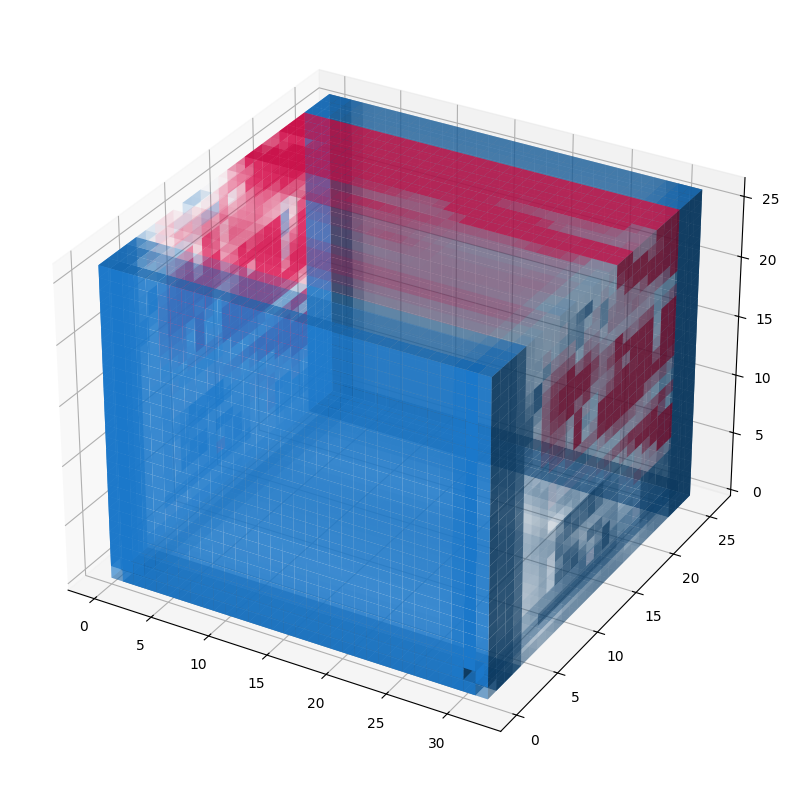

In [50]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection="3d")
ax.voxels(svs, facecolors=facecolor_s)
plt.savefig("svs.png", transparent=True)
plt.show()

In [47]:
svs /= 1.2

<Axes: >

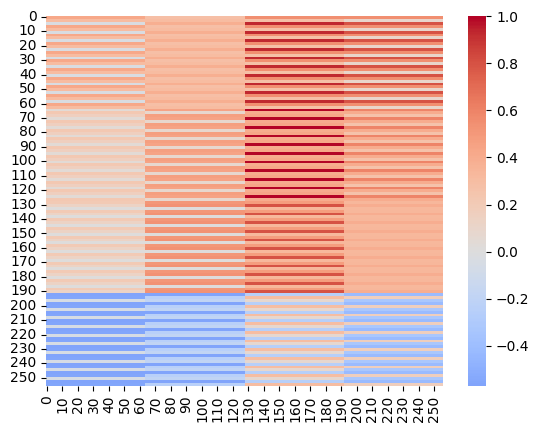

In [ ]:
import seaborn as sns

sns.heatmap(shap_gt[0,0,0].cpu().detach().numpy(), cmap="coolwarm", center=0)

<Axes: >

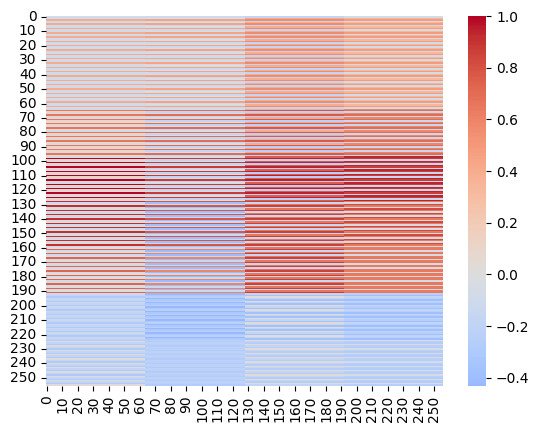

In [ ]:
sns.heatmap(shap_gt2[0,0,0].cpu().detach().numpy(), cmap="coolwarm", center=0)

<Axes: >

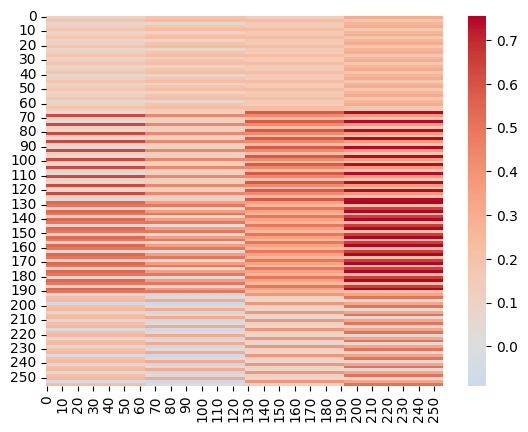

In [ ]:
sns.heatmap(shap_gt3[0,0,0].cpu().detach().numpy(), cmap="coolwarm", center=0)

<Axes: >

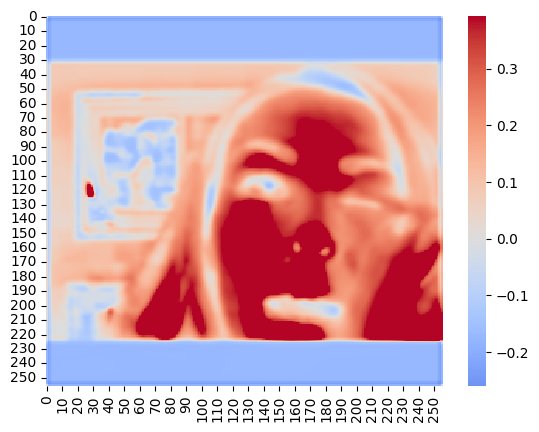

In [ ]:
sns.heatmap(mu[0,0,0].cpu().detach().numpy(), cmap="coolwarm", center=0)

In [ ]:
prob_val = loss.compute_norm_prob(mu, 0.2, shap_gt)
loss_energy = mu * prob_val

In [ ]:
prob_val2 = loss2.compute_norm_prob(mu, 0.2, shap_gt2)
loss_energy2 = mu * prob_val2

In [ ]:
prob_val3 = loss3.compute_norm_prob(mu, 0.2, shap_gt3)
loss_energy3 = mu * prob_val3

In [ ]:
sigma.mean(), sigma.std()

(tensor(0.0003, grad_fn=<MeanBackward0>),
 tensor(0.0008, grad_fn=<StdBackward0>))

<Axes: >

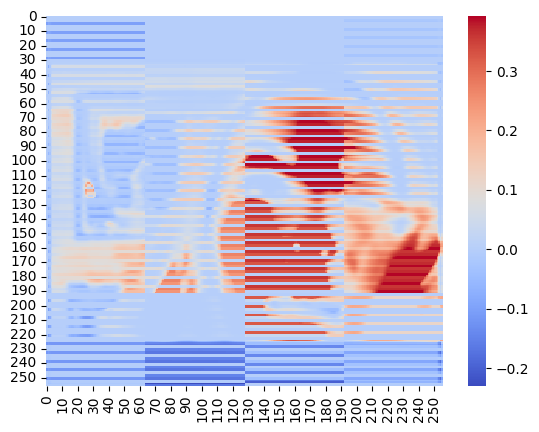

In [ ]:
sns.heatmap(loss_energy[0,0,0].cpu().detach().numpy(), cmap="coolwarm")

<Axes: >

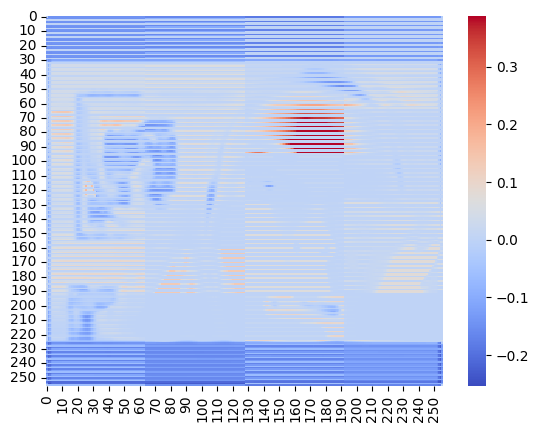

In [ ]:
sns.heatmap(loss_energy2[0,0,0].cpu().detach().numpy(), cmap="coolwarm")

<Axes: >

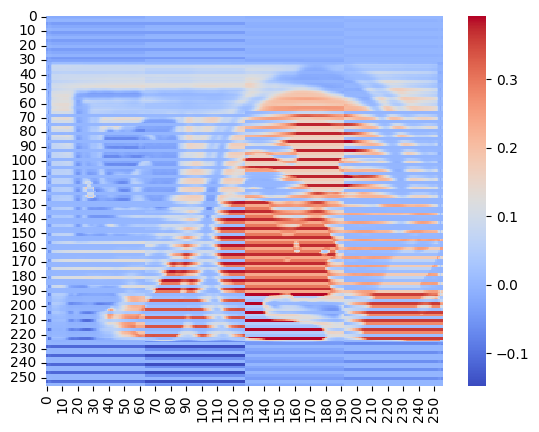

In [ ]:
sns.heatmap(loss_energy3[0,0,0].cpu().detach().numpy(), cmap="coolwarm")

<Axes: >

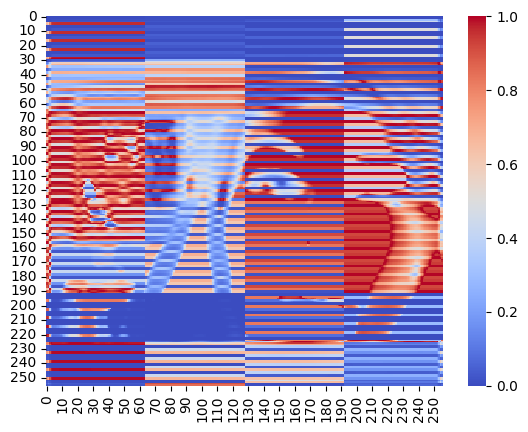

In [ ]:
sns.heatmap(prob_val[0,0,14].cpu().detach().numpy(), cmap="coolwarm")

<Axes: >

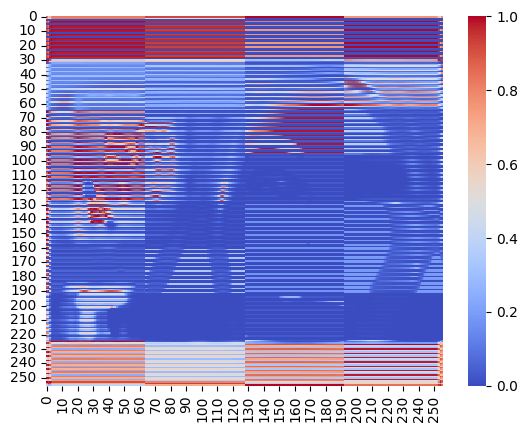

In [ ]:
sns.heatmap(prob_val2[0,0,14].cpu().detach().numpy(), cmap="coolwarm")

<Axes: >

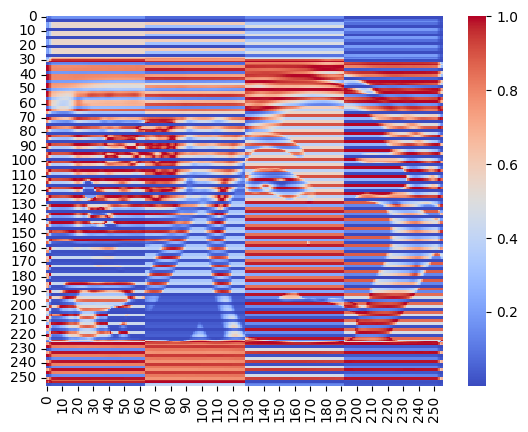

In [ ]:
sns.heatmap(prob_val3[0,0,14].cpu().detach().numpy(), cmap="coolwarm")